In [1]:
'''Create variable distributions of collections'''

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#from PhenoColl.extraction import *
import numpy as np
import pandas as pd
import random as rdm
import scipy
import copy
import os
import scipy.stats as stats
from scipy.stats import skewnorm

In [3]:
#Read in Simulated Data -consists of locations, years, and corresponding conditions for all randomly selected points
test_data = pd.read_csv('Data/Full_Simulation_30Taxa_1kSamples.csv')


print(len(test_data))
test_data.head()

50000


Unnamed: 0           X          Y  Ann_tmean_norm  Ann_ppt_norm  year  \
0      246566  -88.125000  41.208333       10.111964    890.465515  1950   
1      130267  -88.583333  36.541667       14.817737   1271.913086  1950   
2      430775 -115.916667  46.500000        7.001530    966.874634  1950   
3       39363  -94.541667  32.208333       18.600447   1183.383423  1950   
4      365157  -96.291667  42.625000        8.936030    663.298950  1950   

  genus_species                                      geometry  Ann_ppt_13  \
0       Taxon_1   POINT (-88.12499999970451 41.2083333332635)   78.270500   
1       Taxon_1  POINT (-88.58333333304152 36.54166666655951)  148.946751   
2       Taxon_1  POINT (-115.9166666665935 46.49999999997249)  101.797000   
3       Taxon_1    POINT (-94.5416666664225 32.2083333331915)   97.459834   
4       Taxon_1   POINT (-96.29166666643648 42.6249999999415)   50.334332   

   Prev_ppt_13  ...  Anomaly_vpdmax_10  Ann_vpdmax_11  Prev_vpdmax_11  \
0    76.531749  ...          -1.333680          4.935           6.436   
1   127.460165  ...          -1.268101          7.932          11.553   
2    71.578250  ...           0.975998          2.859           6.374   
3   113.223499  ...          -1.077320         13.871          17.421   
4    62.793916  ...          -2.601300          7.002           9.585   

   Norm_vpdmax_11_1901_2000  Anomaly_vpdmax_11  Ann_vpdmax_12  Prev_vpdmax_12  \
0                  5.726900           0.791900          1.554           3.548   
1                  9.213720           1.281720          4.484           7.337   
2                  3.934350           1.075350          1.383           2.471   
3                 12.438791          -1.432209          9.985           9.576   
4                  5.973450          -1.028550          2.718           4.260   

   Norm_vpdmax_12_1901_2000  Anomaly_vpdmax_12  unique_ID  
0                  2.761329           1.207329          0  
1                  5.285360           0.801360          1  
2                  2.329350           0.946350          2  
3                  8.826859          -1.158140          3  
4                  3.066470           0.348470          4  

[5 rows x 366 columns]

In [8]:
#subroutine to create random collection dates for a collection assuming no bias in collection date
#requires start and end DOYs for that individual
def rand_flat(row):
    start = row['Local_indiv_onset_DOY']
    end = row['Local_indiv_termination_DOY']
    out = rdm.randint(int(start), int(end))
    return(out)

#subroutine to create random collection dates for a collection assuming a bias towards collection proximate to peak or median flowering date.
#requires start and end DOYs for that individual
def normal_trunc(row):
    start = row['Local_indiv_onset_DOY']
    end = row['Local_indiv_termination_DOY']
    duration = row['local_duration']
    
    
    out_rand = -99999999999999999999999999999.0
    while ((out_rand < start) | (out_rand > end)):
        out_rand = np.random.normal(loc = row['Local_indiv_mean_DOY'], scale = duration/4, size = 1)[0]
    out_rand = round(out_rand)
    return out_rand


#subroutine to create random collection dates for a collection assuming a bias towards collection proximate to individual flowering onset
#requires start and end DOYs for that individual
def left_trunc(row):
    start = row['Local_indiv_onset_DOY']
    end = row['Local_indiv_termination_DOY']
    duration = row['local_duration']
    
    out_rand = -99999999999999999999999999999.0
    while ((out_rand < start) | (out_rand > end)):
        out_rand = np.random.normal(loc = row['Local_indiv_onset_DOY'] + (duration/4), scale = duration/4, size = 1)[0]
    out_rand = round(out_rand)
    return out_rand

#subroutine to create random collection dates for a collection assuming a bias towards collection proximate to individual flowering termination
#requires start and end DOYs for that individual
def right_trunc(row):
    start = row['Local_indiv_onset_DOY']
    end = row['Local_indiv_termination_DOY']
    duration = row['local_duration']
    
    out_rand = -99999999999999999999999999999.0
    while ((out_rand < start) | (out_rand > end)):
        out_rand = np.random.normal(loc = row['Local_indiv_onset_DOY'] + (duration*0.75), scale = duration/4, size = 1)[0]
    out_rand = round(out_rand)
    return out_rand


#creates simulated phenological info (including population-level and individual-level phenological timings, as well as collection dates) for a single set of phenological and population-level parameters
#produces all forms of individual collection bias
def distribution_simulation(in_data, slope, param, duration,  sigma, noise = 0, sigma_diff = 0, duration_diff = 0, intercept = 50, skew = 0):
    '''
    :param in_data: input data
    :param slope:   slope of relationship
    :param duration: duration of flowering
    :param sigma: degree of intrapopulation variation in mean timing
    :param duration_diff: rate at which individual flowering duration changes along climate gradient
    :param noise: magnitude of unexplained variation in phenological timing (in population-level median flowering times) - defaults to 0
    :param intercept: intercept 
    :param skew: degree to which collection dates are biased towards individuals with earlier (skew <0) or later (skew >0) than average timings.  Independent of biases towards collection of specimens that are proximate to the onset or termination dates of individual flowering.
    '''
    
    
    
    in_data['Local_50pct_mean_DOY'] = (in_data[param] * slope) + intercept
    
    if noise > 0:
        in_data['Local_50pct_mean_DOY'] = in_data['Local_50pct_mean_DOY'] + np.random.randint((noise/-2),(noise/2), size=len(in_data))
    
    in_data['local_sigma'] = sigma + (in_data[param] * sigma_diff)
    in_data['local_duration'] = duration + (in_data[param] * duration_diff)
    
    in_data['Local_10pct_mean_DOY'] = skewnorm.ppf(0.1, loc = in_data['Local_50pct_mean_DOY'], a = 0, scale = in_data['local_sigma']).round()
    in_data['Local_10pct_onset_DOY'] = (skewnorm.ppf(0.1, loc = in_data['Local_50pct_mean_DOY'], a = 0, scale = in_data['local_sigma']).round()- (in_data['local_duration']/2)).round()
    in_data['Local_90pct_mean_DOY'] = skewnorm.ppf(0.9, loc = in_data['Local_50pct_mean_DOY'], a = 0, scale = in_data['local_sigma']).round()
    in_data['Local_90pct_termination_DOY'] = (skewnorm.ppf(0.9, loc = in_data['Local_50pct_mean_DOY'], a = 0, scale = in_data['local_sigma']).round()- (in_data['local_duration']/2)).round()
    
    
    
    
   
    in_data["genus_species"] = in_data["genus_species"] + str(slope) + '_' + str(param) + '_' + str(sigma) + '_' + str(duration)+ '_' + str(skew)
    in_data['slope'] = slope
    in_data['param'] = param
    in_data['sigma'] = sigma
    in_data['duration'] = duration
    in_data['skew'] = skew
    
    in_data['Local_indiv_mean_DOY'] = skewnorm.rvs(loc = in_data['Local_50pct_mean_DOY'], a = skew, scale = in_data['local_sigma']).round() #extract random date from intrapopulatoin distribution with skew of a - returns an array by defaullt, so [0] extracts the number
    #in_data['Local_indiv_mean_DOY'] = np.random.normal(in_data['Local_50pct_mean_DOY'], in_data['local_sigma']).round()
    in_data['Local_indiv_onset_DOY'] = (in_data['Local_indiv_mean_DOY'] - (in_data['local_duration']/2)).round()
    in_data['Local_indiv_termination_DOY'] = (in_data['Local_indiv_mean_DOY'] + (in_data['local_duration']/2)).round()
    
    
    in_data['Local_sample'] = in_data.apply(normal_trunc, axis=1).round()
    in_data['Local_sample_leftDist'] = in_data.apply(left_trunc, axis=1).round()
    in_data['Local_sample_rightDist'] = in_data.apply(right_trunc, axis=1).round()
    in_data['Local_sample_flatDist'] = in_data.apply(rand_flat, axis=1).round()
    return(in_data)



In [9]:
# create simulated phenological data for all points/species in simulated data for multiple sets of phenological attributes and collection biases.
def data_creater(in_data, out_path, slopes = [0.1, 0.2, 0.5], params = ['Ann_tmean_13'], durations = [5, 10,20, 30, 60, 120], sigmas = [5, 10,20], sigma_diff = 0, noise = 0, duration_diff = 0, intercept = 50, skews = [-1, 0, 1]):
    concat_data = 'nope'
    
    for iter_slope in slopes:
        for iter_sigma in sigmas:
            for iter_param in params:
                for iter_duration in durations:
                    for iter_skew in skews:
                        iter_data = distribution_simulation(in_data= test_data, slope = iter_slope, param = iter_param, noise = noise, duration = iter_duration, 
                                                        sigma = iter_sigma, sigma_diff = sigma_diff, duration_diff = duration_diff, intercept = 50, skew = iter_skew)

                        if type(concat_data) == str:
                            concat_data = copy.deepcopy(iter_data)

                        else:
                            concat_data = pd.concat([concat_data, copy.deepcopy(iter_data)])

    
    concat_data.reset_index(inplace = True, drop = True)
    concat_data.to_csv(out_path)
    
    return concat_data

In [10]:
#variable pop_distribution

data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_Variablesigma_slope1.csv", 
             slopes = [1.0], 
             params = ['Ann_tmean_13'], 
             durations = [15, 30, 60], 
             sigmas = [10], 
             sigma_diff = 1,
             intercept = 50)

data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_Variablesigma_slope4.csv", 
             slopes = [4.0], 
             params = ['Ann_tmean_13'], 
             durations = [15, 30, 60], 
             sigmas = [10], 
             sigma_diff = 1,
             intercept = 50)


data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_Variablesigma_slope8.csv", 
             slopes = [8.0], 
             params = ['Ann_tmean_13'], 
             durations = [15, 30, 60], 
             sigmas = [10], 
             sigma_diff = 1,
             intercept = 50)

Unnamed: 0           X          Y  Ann_tmean_norm  Ann_ppt_norm  year  \
0           246566  -88.125000  41.208333       10.111964    890.465515  1950   
1           130267  -88.583333  36.541667       14.817737   1271.913086  1950   
2           430775 -115.916667  46.500000        7.001530    966.874634  1950   
3            39363  -94.541667  32.208333       18.600447   1183.383423  1950   
4           365157  -96.291667  42.625000        8.936030    663.298950  1950   
...            ...         ...        ...             ...           ...   ...   
449995      280034  -77.833333  39.666667       11.683361    991.373657  2019   
449996      307129 -117.916667  44.291667        6.968212    309.617249  2019   
449997      353694 -101.916667  44.625000        7.944194    409.815277  2019   
449998       20050  -97.791667  31.833333       18.509150    799.015381  2019   
449999      322659 -106.875000  45.750000        7.387192    387.599762  2019   

                                            genus_species  \
0       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
1       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
2       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
3       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
4       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
...                                                   ...   
449995  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   
449996  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   
449997  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   
449998  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   
449999  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   

                                            geometry  Ann_ppt_13  Prev_ppt_13  \
0        POINT (-88.12499999970451 41.2083333332635)   78.270500    76.531749   
1       POINT (-88.58333333304152 36.54166666655951)  148.946751   127.460165   
2       POINT (-115.9166666665935 46.49999999997249)  101.797000    71.578250   
3         POINT (-94.5416666664225 32.2083333331915)   97.459834   113.223499   
4        POINT (-96.29166666643648 42.6249999999415)   50.334332    62.793916   
...                                              ...         ...          ...   
449995    POINT (-77.8333333329555 39.6666666665845)   92.003916   145.860584   
449996   POINT (-117.9166666666095 44.2916666666215)   30.311500    21.317000   
449997   POINT (-101.9166666664815 44.6249999999575)   64.961333    44.576916   
449998  POINT (-97.79166666644848 31.83333333318849)   63.444416   105.394251   
449999   POINT (-106.8749999998545 45.7499999999665)   53.033750    52.273082   

        ...  sigma  duration  skew  Local_indiv_mean_DOY  \
0       ...     10        15    -1                 137.0   
1       ...     10        15    -1                 144.0   
2       ...     10        15    -1                  82.0   
3       ...     10        15    -1                 204.0   
4       ...     10        15    -1                  82.0   
...     ...    ...       ...   ...                   ...   
449995  ...     10        60     1                 158.0   
449996  ...     10        60     1                  84.0   
449997  ...     10        60     1                 104.0   
449998  ...     10        60     1                 220.0   
449999  ...     10        60     1                 108.0   

        Local_indiv_onset_DOY  Local_indiv_termination_DOY  Local_sample  \
0                       130.0                        144.0           135   
1                       136.0                        152.0           145   
2                        74.0                         90.0            79   
3                       196.0                        212.0           205   
4                        74.0                         90.0            84   
...                       ...                          ...           ...   
449995                  128.0                        188.0           157   


In [11]:
#run data creator with different population-level skews
data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_slope4_skewDistribution.csv", 
             slopes = [4.0], 
             params = ['Ann_tmean_13'], 
             durations = [30], 
             sigmas = [30],
             sigma_diff = 0,
             intercept = 50,
            skews = [ 1, 0.5, 0.25,  0, -0.25, -0.5, -1])

Unnamed: 0           X          Y  Ann_tmean_norm  Ann_ppt_norm  year  \
0           246566  -88.125000  41.208333       10.111964    890.465515  1950   
1           130267  -88.583333  36.541667       14.817737   1271.913086  1950   
2           430775 -115.916667  46.500000        7.001530    966.874634  1950   
3            39363  -94.541667  32.208333       18.600447   1183.383423  1950   
4           365157  -96.291667  42.625000        8.936030    663.298950  1950   
...            ...         ...        ...             ...           ...   ...   
349995      280034  -77.833333  39.666667       11.683361    991.373657  2019   
349996      307129 -117.916667  44.291667        6.968212    309.617249  2019   
349997      353694 -101.916667  44.625000        7.944194    409.815277  2019   
349998       20050  -97.791667  31.833333       18.509150    799.015381  2019   
349999      322659 -106.875000  45.750000        7.387192    387.599762  2019   

                                            genus_species  \
0       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
1       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
2       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
3       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
4       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
...                                                   ...   
349995  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   
349996  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   
349997  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   
349998  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   
349999  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   

                                            geometry  Ann_ppt_13  Prev_ppt_13  \
0        POINT (-88.12499999970451 41.2083333332635)   78.270500    76.531749   
1       POINT (-88.58333333304152 36.54166666655951)  148.946751   127.460165   
2       POINT (-115.9166666665935 46.49999999997249)  101.797000    71.578250   
3         POINT (-94.5416666664225 32.2083333331915)   97.459834   113.223499   
4        POINT (-96.29166666643648 42.6249999999415)   50.334332    62.793916   
...                                              ...         ...          ...   
349995    POINT (-77.8333333329555 39.6666666665845)   92.003916   145.860584   
349996   POINT (-117.9166666666095 44.2916666666215)   30.311500    21.317000   
349997   POINT (-101.9166666664815 44.6249999999575)   64.961333    44.576916   
349998  POINT (-97.79166666644848 31.83333333318849)   63.444416   105.394251   
349999   POINT (-106.8749999998545 45.7499999999665)   53.033750    52.273082   

        ...  sigma  duration  skew  Local_indiv_mean_DOY  \
0       ...     30        30   1.0                 103.0   
1       ...     30        30   1.0                  92.0   
2       ...     30        30   1.0                  90.0   
3       ...     30        30   1.0                 126.0   
4       ...     30        30   1.0                 125.0   
...     ...    ...       ...   ...                   ...   
349995  ...     30        30  -1.0                 125.0   
349996  ...     30        30  -1.0                  52.0   
349997  ...     30        30  -1.0                  40.0   
349998  ...     30        30  -1.0                 121.0   
349999  ...     30        30  -1.0                  82.0   

        Local_indiv_onset_DOY  Local_indiv_termination_DOY  Local_sample  \
0                        88.0                        118.0           100   
1                        77.0                        107.0            90   
2                        75.0                        105.0           100   
3                       111.0                        141.0           116   
4                       110.0                        140.0           118   
...                       ...                          ...           ...   
349995                  110.0                        140.0           117   


In [12]:
#create simulated phenologies with variable sigmas
data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_Variablesigma_slope1.csv", 
             slopes = [1.0], 
             params = ['Ann_tmean_13'], 
             durations = [15, 30, 60], 
             sigmas = [10],
             noise = 0,
             sigma_diff = 1,
             intercept = 50)

data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_Variablesigma_slope4.csv", 
             slopes = [4.0], 
             params = ['Ann_tmean_13'], 
             durations = [15, 30, 60], 
             sigmas = [10], 
             noise = 0,
             sigma_diff = 1,
             intercept = 50)


data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_Variablesigma_slope8.csv", 
             slopes = [8.0], 
             params = ['Ann_tmean_13'], 
             durations = [15, 30, 60], 
             sigmas = [10], 
             noise = 0,
             sigma_diff = 1,
             intercept = 50)



######

data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_Variablesigma_slope1_noise10.csv", 
             slopes = [1.0], 
             params = ['Ann_tmean_13'], 
             durations = [15, 30, 60], 
             sigmas = [10],
             noise = 10,
             sigma_diff = 1,
             intercept = 50)

data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_Variablesigma_slope4_noise10.csv", 
             slopes = [4.0], 
             params = ['Ann_tmean_13'], 
             durations = [15, 30, 60], 
             sigmas = [10], 
             noise = 10,
             sigma_diff = 1,
             intercept = 50)


data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_Variablesigma_slope8_noise10.csv", 
             slopes = [8.0], 
             params = ['Ann_tmean_13'], 
             durations = [15, 30, 60], 
             sigmas = [10], 
             noise = 10,
             sigma_diff = 1,
             intercept = 50)

#########


data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_Variablesigma_slope1_noise30.csv", 
             slopes = [1.0], 
             params = ['Ann_tmean_13'], 
             durations = [15, 30, 60], 
             sigmas = [10],
             noise = 30,
             sigma_diff = 1,
             intercept = 50)

data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_Variablesigma_slope4_noise30.csv", 
             slopes = [4.0], 
             params = ['Ann_tmean_13'], 
             durations = [15, 30, 60], 
             sigmas = [10], 
             noise = 30,
             sigma_diff = 1,
             intercept = 50)


data_creater(in_data = test_data, 
             out_path = "Data/SimHerb_Data/RQ_Sim_Distribution_Variablesigma_slope8_noise30.csv", 
             slopes = [8.0], 
             params = ['Ann_tmean_13'], 
             durations = [15, 30, 60], 
             sigmas = [30], 
             noise = 30,
             sigma_diff = 1,
             intercept = 50)


Unnamed: 0           X          Y  Ann_tmean_norm  Ann_ppt_norm  year  \
0           246566  -88.125000  41.208333       10.111964    890.465515  1950   
1           130267  -88.583333  36.541667       14.817737   1271.913086  1950   
2           430775 -115.916667  46.500000        7.001530    966.874634  1950   
3            39363  -94.541667  32.208333       18.600447   1183.383423  1950   
4           365157  -96.291667  42.625000        8.936030    663.298950  1950   
...            ...         ...        ...             ...           ...   ...   
449995      280034  -77.833333  39.666667       11.683361    991.373657  2019   
449996      307129 -117.916667  44.291667        6.968212    309.617249  2019   
449997      353694 -101.916667  44.625000        7.944194    409.815277  2019   
449998       20050  -97.791667  31.833333       18.509150    799.015381  2019   
449999      322659 -106.875000  45.750000        7.387192    387.599762  2019   

                                            genus_species  \
0       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
1       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
2       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
3       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
4       Taxon_11.0_Ann_tmean_13_10_15_-11.0_Ann_tmean_...   
...                                                   ...   
449995  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   
449996  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   
449997  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   
449998  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   
449999  Taxon_501.0_Ann_tmean_13_10_15_-11.0_Ann_tmean...   

                                            geometry  Ann_ppt_13  Prev_ppt_13  \
0        POINT (-88.12499999970451 41.2083333332635)   78.270500    76.531749   
1       POINT (-88.58333333304152 36.54166666655951)  148.946751   127.460165   
2       POINT (-115.9166666665935 46.49999999997249)  101.797000    71.578250   
3         POINT (-94.5416666664225 32.2083333331915)   97.459834   113.223499   
4        POINT (-96.29166666643648 42.6249999999415)   50.334332    62.793916   
...                                              ...         ...          ...   
449995    POINT (-77.8333333329555 39.6666666665845)   92.003916   145.860584   
449996   POINT (-117.9166666666095 44.2916666666215)   30.311500    21.317000   
449997   POINT (-101.9166666664815 44.6249999999575)   64.961333    44.576916   
449998  POINT (-97.79166666644848 31.83333333318849)   63.444416   105.394251   
449999   POINT (-106.8749999998545 45.7499999999665)   53.033750    52.273082   

        ...  sigma  duration  skew  Local_indiv_mean_DOY  \
0       ...     30        15    -1                  86.0   
1       ...     30        15    -1                 184.0   
2       ...     30        15    -1                 141.0   
3       ...     30        15    -1                 162.0   
4       ...     30        15    -1                  88.0   
...     ...    ...       ...   ...                   ...   
449995  ...     30        60     1                 213.0   
449996  ...     30        60     1                  85.0   
449997  ...     30        60     1                  94.0   
449998  ...     30        60     1                 263.0   
449999  ...     30        60     1                 118.0   

        Local_indiv_onset_DOY  Local_indiv_termination_DOY  Local_sample  \
0                        78.0                         94.0            84   
1                       176.0                        192.0           184   
2                       134.0                        148.0           135   
3                       154.0                        170.0           157   
4                        80.0                         96.0            91   
...                       ...                          ...           ...   
449995                  183.0                        243.0           215   


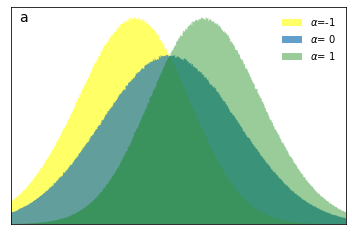

In [13]:
#create histograms demonstrating magnitude of population-level collection skews used in this study 
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import pandas as pd


r = skewnorm.rvs(loc = 50, scale = 30, a= 0, size=10000000)
r2 = skewnorm.rvs(loc = 50, scale = 30, a= 1, size=10000000)
r3 = skewnorm.rvs(loc = 50, scale = 30, a= -1, size=10000000)



#r3 = skewnorm.rvs(loc = 50, scale = 30, a= -2, size=1000)
#r4 = skewnorm.rvs(loc = 50, scale = 30, a= -3, size=1000)
#r5 = skewnorm.rvs(loc = 50, scale = 30, a= -4, size=1000)
x = np.linspace(skewnorm.ppf(0.01, loc = 50, scale = 30, a= 0),
                skewnorm.ppf(0.99, loc = 50, scale = 30, a= 1), 100)

fig, ax = plt.subplots(1, 1)


ax.hist(r3, density=True, bins='auto', histtype='stepfilled', alpha=0.6, color = 'yellow')
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha = 0.7)
ax.hist(r2, density=True, bins='auto', histtype='stepfilled', alpha=0.4, color = 'green')

plt.xticks([])
plt.yticks([])
plt.text(-14, 0.016, 'a', fontsize = 14, horizontalalignment = 'center')
#ax.hist(r3, density=True, bins='auto', histtype='stepfilled', alpha=0.25, color = 'yellow')
#ax.hist(r3, density=True, bins='auto', histtype='stepfilled', alpha=0.25, color = 'orange')
#ax.hist(r4, density=True, bins='auto', histtype='stepfilled', alpha=0.25, color = 'red')

ax.set_xlim([x[0], x[-1]])

ax.legend([r'$\alpha$' + '=-1', r'$\alpha$' + '= 0', r'$\alpha$' + '= 1'], loc='best', frameon=False)
plt.savefig('Data/Figs/A1_hist.png')

plt.show()

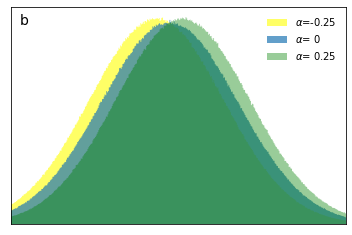

In [14]:
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import pandas as pd


r = skewnorm.rvs(loc = 50, scale = 30, a= 0, size=10000000)
r2 = skewnorm.rvs(loc = 50, scale = 30, a= .25, size=10000000)
r3 = skewnorm.rvs(loc = 50, scale = 30, a= -.25, size=10000000)



#r3 = skewnorm.rvs(loc = 50, scale = 30, a= -2, size=1000)
#r4 = skewnorm.rvs(loc = 50, scale = 30, a= -3, size=1000)
#r5 = skewnorm.rvs(loc = 50, scale = 30, a= -4, size=1000)
x = np.linspace(skewnorm.ppf(0.01, loc = 50, scale = 30, a= 0),
                skewnorm.ppf(0.99, loc = 50, scale = 30, a= 1), 100)

fig, ax = plt.subplots(1, 1)


ax.hist(r3, density=True, bins='auto', histtype='stepfilled', alpha=0.6, color = 'yellow')
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha = 0.7)
ax.hist(r2, density=True, bins='auto', histtype='stepfilled', alpha=0.4, color = 'green')

plt.xticks([])
plt.yticks([])
plt.text(-14, 0.0132, 'b', fontsize = 14, horizontalalignment = 'center')
#ax.hist(r3, density=True, bins='auto', histtype='stepfilled', alpha=0.25, color = 'yellow')
#ax.hist(r3, density=True, bins='auto', histtype='stepfilled', alpha=0.25, color = 'orange')
#ax.hist(r4, density=True, bins='auto', histtype='stepfilled', alpha=0.25, color = 'red')

ax.set_xlim([x[0], x[-1]])

ax.legend([r'$\alpha$' + '=-0.25', r'$\alpha$' + '= 0', r'$\alpha$' + '= 0.25'], loc='best', frameon=False)
plt.savefig('Data/Figs/A025_hist.png')

plt.show()